In [137]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
!pip install pyramid
from pmdarima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [138]:
covid=pd.read_csv("/content/TAMILNADU (1).csv")
covid.head()

,date,state,confirmed,new conf,recovered,new rec,dead,new dead,other,tested
0,04-01-2021,Tamil Nadu,889490.000000,2817.000000,859709.000000,1634.000000,12738.000000,19.000000,0.000000,19681244.000000
1,04-02-2021,Tamil Nadu,892780.000000,3290.000000,861424.000000,1715.000000,12750.000000,12.000000,0.000000,19767310.000000
2,04-03-2021,Tamil Nadu,896226.000000,3446.000000,863258.000000,1834.000000,12764.000000,14.000000,0.000000,19849388.000000
3,04-04-2021,Tamil Nadu,899807.000000,3581.000000,865071.000000,1813.000000,12778.000000,14.000000,0.000000,19932179.000000
4,04-05-2021,Tamil Nadu,903479.000000,3672.000000,866913.000000,1842.000000,12789.000000,11.000000,0.000000,20012235.000000


In [139]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (184, 10)
Checking for null values:
 date         1
state        1
confirmed    1
new conf     1
recovered    1
new rec      1
dead         1
new dead     1
other        1
tested       1
dtype: int64
Checking Data-type of each column:
 date          object
state         object
confirmed    float64
new conf     float64
recovered    float64
new rec      float64
dead         float64
new dead     float64
other        float64
tested       float64
dtype: object


In [140]:
covid["date"]=pd.to_datetime(covid["date"])

In [141]:
grouped=covid.groupby(["state","date"]).agg({"confirmed":'sum',"recovered":'sum',"new dead":'sum'})
grouped

confirmed      recovered  new dead
state      date                                              
Tamil Nadu 2021-04-01  889490.000000  859709.000000 19.000000
           2021-04-02  892780.000000  861424.000000 12.000000
           2021-04-03  896226.000000  863258.000000 14.000000
           2021-04-04  899807.000000  865071.000000 14.000000
           2021-04-05  903479.000000  866913.000000 11.000000
...                              ...            ...       ...
           2021-09-26 2657266.000000 2604491.000000 14.000000
           2021-09-27 2658923.000000 2606153.000000 19.000000
           2021-09-28 2660553.000000 2607796.000000 17.000000
           2021-09-29 2662177.000000 2609435.000000 24.000000
           2021-09-30 2663789.000000 2611061.000000 28.000000

[183 rows x 3 columns]

In [142]:
grouped["Active Cases"]=grouped["confirmed"]-grouped["recovered"]-grouped["new dead"]
grouped["log_confirmed"]=np.log(grouped["confirmed"])
grouped["log_active"]=np.log(grouped["Active Cases"])
grouped

confirmed      recovered  ...  log_confirmed  log_active
state      date                                      ...                           
Tamil Nadu 2021-04-01  889490.000000  859709.000000  ...      13.698404   10.300988
           2021-04-02  892780.000000  861424.000000  ...      13.702095   10.352778
           2021-04-03  896226.000000  863258.000000  ...      13.705948   10.402868
           2021-04-04  899807.000000  865071.000000  ...      13.709936   10.455129
           2021-04-05  903479.000000  866913.000000  ...      13.714008   10.506573
...                              ...            ...  ...            ...         ...
           2021-09-26 2657266.000000 2604491.000000  ...      14.792808   10.873528
           2021-09-27 2658923.000000 2606153.000000  ...      14.793432   10.873338
           2021-09-28 2660553.000000 2607796.000000  ...      14.794045   10.873129
           2021-09-29 2662177.000000 2609435.000000  ...      14.794655   10.872712
           2021-09-30 2663789.000000 2611061.000000  ...      14.795260   10.872371

[183 rows x 6 columns]

In [143]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["date"]).agg({"confirmed":'sum',"recovered":'sum',"new dead":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise

,confirmed,recovered,new dead,Days Since
date,,,,
2021-04-01,889490.000000,859709.000000,19.000000,0 days
2021-04-02,892780.000000,861424.000000,12.000000,1 days
2021-04-03,896226.000000,863258.000000,14.000000,2 days
2021-04-04,899807.000000,865071.000000,14.000000,3 days
2021-04-05,903479.000000,866913.000000,11.000000,4 days
...,...,...,...,...
2021-09-26,2657266.000000,2604491.000000,14.000000,178 days
2021-09-27,2658923.000000,2606153.000000,19.000000,179 days
2021-09-28,2660553.000000,2607796.000000,17.000000,180 days


In [144]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["state"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["new dead"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["confirmed"].iloc[-1]-datewise["recovered"].iloc[-1]-datewise["new dead"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["recovered"].iloc[-1]+datewise["new dead"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["new dead"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["new dead"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["confirmed"].iloc[-1]-datewise["confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["recovered"].iloc[-1]-datewise["recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["new dead"].iloc[-1]-datewise["new dead"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  2
Total number of Confirmed Cases around the World:  2663789.0
Total number of Recovered Cases around the World:  2611061.0
Total number of Deaths Cases around the World:  28.0
Total number of Active Cases around the World:  52700.0
Total number of Closed Cases around the World:  2611089.0
Approximate number of Confirmed Cases per Day around the World:  14556.0
Approximate number of Recovered Cases per Day around the World:  14268.0
Approximate number of Death Cases per Day around the World:  0.0
Approximate number of Confirmed Cases per hour around the World:  607.0
Approximate number of Recovered Cases per hour around the World:  595.0
Approximate number of Death Cases per hour around the World:  0.0
Number of Confirmed Cases in last 24 hours:  1612.0
Number of Recovered Cases in last 24 hours:  1626.0
Number of Death Cases in last 24 hours:  4.0


In [145]:
fig=px.bar(x=datewise.index,y=datewise["new dead"])
fig.update_layout(title="Distribution of Number of new dead Cases",
                  xaxis_title="Date",yaxis_title="Number of deaths",)
fig.show()

In [146]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["new dead"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in Tamil Nadu",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

GROWTH RATE OF TAMIL NADU


In [147]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new dead"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [148]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["new dead"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new dead"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  9696.0
Average increase in number of Recovered Cases every day:  9570.0
Average increase in number of Deaths Cases every day:  0.0


GROWTH FACTOR


In [149]:
#linear regression


In [150]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [151]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [152]:
lin_reg=LinearRegression(normalize=True)

In [153]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["new dead"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [154]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [155]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["new dead"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["new dead"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  7.284517382762753


In [156]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="newly dead Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [157]:
#polynomial regression 
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
poly = PolynomialFeatures(degree = 8) 

In [158]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["new dead"]

In [159]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [160]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["new dead"],prediction_poly))
model_scores=[]
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  222.31543032355302


In [161]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="new dead Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


<Figure size 792x432 with 0 Axes>

SVM PREDICTION

In [162]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [163]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [164]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["new dead"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [165]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [166]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["new dead"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["new dead"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  70.95519782123728


In [167]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="newly dead Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [168]:
#new polynomial
new_prediction_poly=[]
for i in range(1,365):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [169]:
#new svm prediction
new_date=[]
new_prediction_svm=[]
for i in range(1,365):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [170]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly,new_prediction_svm),
                               columns=["date","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction
0,2021-10-01,-499.285549,-72.588312
1,2021-10-02,-607.329887,-77.593260
2,2021-10-03,-731.575222,-82.736075
3,2021-10-04,-873.786531,-88.019780
4,2021-10-05,-1035.867634,-93.447445
...,...,...,...
359,2022-09-25,-2680761230.060899,-101559.261814
360,2022-09-26,-2729687264.483240,-102689.599982
361,2022-09-27,-2779390640.694740,-103830.394455
362,2022-09-28,-2829881890.774805,-104981.722527


FORECASTING

HOLT'S LINEAR MODEL

In [171]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [172]:
holt=Holt(np.asarray(model_train["new dead"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)     

In [173]:
y_pred["Holt"]=holt.forecast(10)
model_scores.append(np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  4.574375403845237


In [174]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for newly dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of newly dead Cases",))
fig.update_layout(title="newly dead Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [175]:
#holt new prediction
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,365):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2021-10-01,-499.285549,-72.588312,20.175243
1,2021-10-02,-607.329887,-77.593260,19.904444
2,2021-10-03,-731.575222,-82.736075,19.633645
3,2021-10-04,-873.786531,-88.019780,19.362846
4,2021-10-05,-1035.867634,-93.447445,19.092047
...,...,...,...,...
359,2022-09-25,-2680761230.060899,-101559.261814,-77.041554
360,2022-09-26,-2729687264.483240,-102689.599982,-77.312353
361,2022-09-27,-2779390640.694740,-103830.394455,-77.583152
362,2022-09-28,-2829881890.774805,-104981.722527,-77.853951


HOLT'S WINTER MODEL

In [176]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [177]:
es=ExponentialSmoothing(np.asarray(model_train['new dead']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [178]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  8.235375181923512


In [179]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for new dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for newly dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of newly dead Cases",))
fig.update_layout(title="newly dead Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="new dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [180]:
#holt winter new prediction
holt_winter_new_prediction=[]
for i in range(1,365):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475


In [181]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

AR MODEL (AUTO ARIMA)

In [182]:
model_ar= auto_arima(model_train["confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["new dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2706.896, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2708.884, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2710.828, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2712.725, Time=0.23 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2714.460, Time=0.33 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.782 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [183]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [184]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  23.85935887336355


In [185]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for newly dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of newly dead Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [186]:
#ar model new prediction
AR_model_new_prediction=[]
for i in range(1,365):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972,-19.842105
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473,-23.631579
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771,-27.403509
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276,-31.157895
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475,-34.894737


MA MODEL (AUTO ARIMA)

In [187]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [188]:
model_ma= auto_arima(model_train["new dead"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["new dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1693.439, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1548.162, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1512.686, Time=0.08 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 0.154 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [189]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [190]:
model_scores.append(np.sqrt(mean_squared_error(valid["new dead"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["new dead"],prediction_ma)))

Root Mean Square Error for MA Model:  4.604344700732157


In [191]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for newly dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for newly dead Cases",))
fig.update_layout(title="newly dead Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [192]:
#ma model new prediction
MA_model_new_prediction=[]
for i in range(1,365):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head(60)

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972,-19.842105,20.465027
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473,-23.631579,20.159600
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771,-27.403509,19.852915
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276,-31.157895,19.544972
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475,-34.894737,19.235770
5,2021-10-06,-1219.868903,-99.022191,18.821248,29.794385,-38.614035,18.925310
6,2021-10-07,-1427.995268,-104.747190,18.550449,33.915458,-42.315789,18.613591
7,2021-10-08,-1662.614515,-110.625664,18.279650,36.942003,-46.000000,18.300614
8,2021-10-09,-1926.265888,-116.660887,18.008851,37.661722,-49.666667,17.986379
9,2021-10-10,-2221.668993,-122.856185,17.738053,31.339385,-53.315789,17.670886


ARIMA MODEL (AUTO ARIMA)

In [193]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [194]:
model_arima= auto_arima(model_train["new dead"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["new dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1693.439, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1548.162, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1512.686, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1503.129, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1629.964, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1534.096, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1502.720, Time=0.16 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1504.646, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1579.361, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1519.345, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1504.693, Time=0.22 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1521.378, Time=0.43 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1541.360, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1517.902, Time=0.13 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1515.576, Time=0.30 sec

Best mode

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [195]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [196]:
model_scores.append(np.sqrt(mean_squared_error(valid["new dead"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["new dead"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  5.5450768792721705


In [197]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for newly dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for newly dead Cases",))
fig.update_layout(title="newly dead Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [198]:
ARIMA_model_new_prediction=[]
for i in range(1,365):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972,-19.842105,20.465027,14.901234
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473,-23.631579,20.159600,13.849420
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771,-27.403509,19.852915,12.800769
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276,-31.157895,19.544972,11.755290
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475,-34.894737,19.235770,10.712987


SARIMA MODEL (AUTO ARIMA)

In [199]:
model_sarima= auto_arima(model_train["new dead"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["new dead"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1686.464, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1691.439, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1615.810, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1541.271, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1546.194, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1533.747, Time=0.22 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1538.889, Time=0.10 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1535.321, Time=0.32 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1535.141, Time=0.53 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1540.078, Time=0.31 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1536.216, Time=0.26 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=1.11 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1512.310, Time=0.23 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1522.913, Time=0.15 sec
 ARIMA(1,2,1)(1,0,0)[7]             : 

ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [200]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [201]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["new dead"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  5.253790627501106


In [202]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for newly dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for newly dead Cases",))
fig.update_layout(title="newly dead Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="new dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [203]:
SARIMA_model_new_prediction=[]
for i in range(1,365):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972,-19.842105,20.465027,14.901234,15.658218
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473,-23.631579,20.159600,13.849420,16.305390
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771,-27.403509,19.852915,12.800769,15.343404
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276,-31.157895,19.544972,11.755290,13.538411
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475,-34.894737,19.235770,10.712987,13.953690
...,...,...,...,...,...,...,...,...,...
359,2022-09-25,-2680761230.060899,-101559.261814,-77.041554,150.172634,-252.877193,-170.044347,-158.498618,-533.570418
360,2022-09-26,-2729687264.483240,-102689.599982,-77.312353,150.184203,-250.368421,-170.801512,-158.409619,-535.145916
361,2022-09-27,-2779390640.694740,-103830.394455,-77.583152,174.875108,-247.842105,-171.559935,-158.317441,-536.721414
362,2022-09-28,-2829881890.774805,-104981.722527,-77.853951,177.463469,-245.298246,-172.319617,-158.222086,-538.296913


FB PROPHET

In [204]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_dead=pd.DataFrame(zip(list(datewise.index),list(datewise["new dead"])),columns=['ds','y'])

In [205]:
prophet_c.fit(prophet_dead)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [206]:
forecast_c=prophet_c.make_future_dataframe(periods=364)
forecast_dead=forecast_c.copy()

In [207]:
dead_forecast=prophet_c.predict(forecast_c)
print(dead_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds        yhat   yhat_lower  yhat_upper
0   2021-04-01  181.546503   -68.733359  405.575316
1   2021-04-02  188.041521   -51.065858  426.576423
2   2021-04-03  187.313013   -58.375293  422.191273
3   2021-04-04  178.504187   -56.334335  435.329561
4   2021-04-05  174.384711   -55.556781  430.804290
..         ...         ...          ...         ...
542 2022-09-25 -645.506939 -1029.714347 -236.157765
543 2022-09-26 -651.586966 -1056.939089 -227.851328
544 2022-09-27 -639.743935 -1031.831934 -213.777928
545 2022-09-28 -639.204982 -1014.554256 -220.356539
546 2022-09-29 -648.778924 -1061.791136 -232.897307

[547 rows x 4 columns]


In [208]:
model_scores.append(np.sqrt(mean_squared_error(datewise["new dead"],dead_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["new dead"],dead_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  120.40678939046899


Figure(720x432)


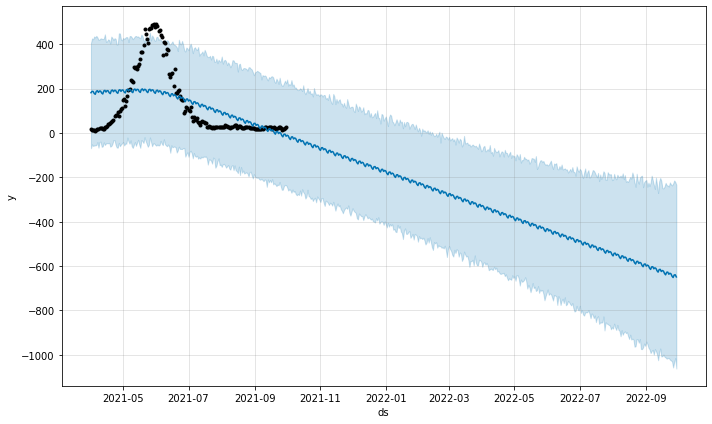

In [209]:
print(prophet_c.plot(dead_forecast))

Figure(648x432)


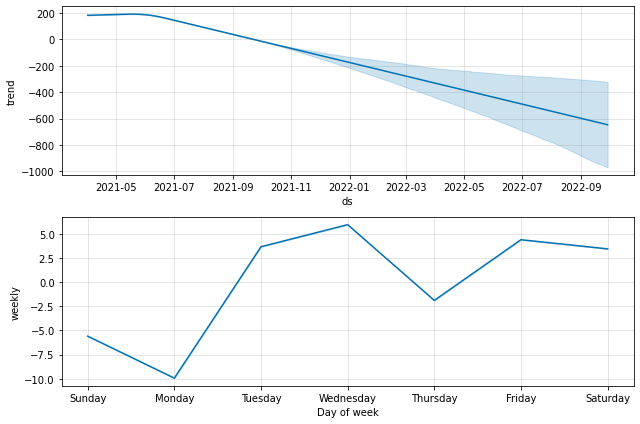

In [210]:
print(prophet_c.plot_components(dead_forecast))

In [211]:
model_names=["Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
2,Holt's Linear,4.574375
5,Moving Average Model (MA),4.604345
7,SARIMA Model,5.253791
6,ARIMA Model,5.545077
3,Holt's Winter Model,8.235375
4,Auto Regressive Model (AR),23.859359
1,Support Vector Machine Regressor,70.955198
8,Facebook's Prophet Model,120.406789
0,Polynomial Regression,222.315430


In [212]:
model_predictions["Prophet's Prediction"]=list(dead_forecast["yhat"].tail(364))
model_predictions["Prophet's Upper Bound"]=list(dead_forecast["yhat_upper"].tail(364))
model_predictions["Prophet's Lower Bound"]=list(dead_forecast["yhat_lower"].tail(364))
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Prophet's Lower Bound
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972,-19.842105,20.465027,14.901234,15.658218,-10.054766,241.218605,-245.062428
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473,-23.631579,20.159600,13.849420,16.305390,-12.743825,213.727764,-259.439164
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771,-27.403509,19.852915,12.800769,15.343404,-23.513203,220.871632,-253.666272
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276,-31.157895,19.544972,11.755290,13.538411,-29.593230,216.829212,-257.179777
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475,-34.894737,19.235770,10.712987,13.953690,-17.750199,238.575567,-269.568722
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-09-25,-2680761230.060899,-101559.261814,-77.041554,150.172634,-252.877193,-170.044347,-158.498618,-533.570418,-645.506939,-236.157765,-1029.714347
360,2022-09-26,-2729687264.483240,-102689.599982,-77.312353,150.184203,-250.368421,-170.801512,-158.409619,-535.145916,-651.586966,-227.851328,-1056.939089
361,2022-09-27,-2779390640.694740,-103830.394455,-77.583152,174.875108,-247.842105,-171.559935,-158.317441,-536.721414,-639.743935,-213.777928,-1031.831934
362,2022-09-28,-2829881890.774805,-104981.722527,-77.853951,177.463469,-245.298246,-172.319617,-158.222086,-538.296913,-639.204982,-220.356539,-1014.554256


In [213]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [214]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [215]:
model_arima_deaths=auto_arima(model_train["new dead"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["new dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1693.439, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1548.162, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1512.686, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1503.129, Time=0.13 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=1504.831, Time=0.23 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=1506.262, Time=0.42 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1629.964, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1534.096, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1502.720, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1504.646, Time=0.24 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=1503.154, Time=0.31 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1579.361, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1519.345, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1504.693, Time=0.22 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1521.378, Time=0.45 sec
 ARIMA(3,2

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [216]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [217]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["new dead"],predictions_deaths)))

Root Mean Square Error:  5.5450768792721705


In [218]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new dead"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new dead"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [219]:
ARIMA_model_death_forecast=[]
for i in range(1,365):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [220]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2021-10-01,14.901234
1,2021-10-02,13.849420
2,2021-10-03,12.800769
3,2021-10-04,11.755290
4,2021-10-05,10.712987


In [221]:
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Prophet's Lower Bound
0,2021-10-01,-499.285549,-72.588312,20.175243,23.229972,-19.842105,20.465027,14.901234,15.658218,-10.054766,241.218605,-245.062428
1,2021-10-02,-607.329887,-77.593260,19.904444,28.044473,-23.631579,20.159600,13.849420,16.305390,-12.743825,213.727764,-259.439164
2,2021-10-03,-731.575222,-82.736075,19.633645,31.100771,-27.403509,19.852915,12.800769,15.343404,-23.513203,220.871632,-253.666272
3,2021-10-04,-873.786531,-88.019780,19.362846,27.716276,-31.157895,19.544972,11.755290,13.538411,-29.593230,216.829212,-257.179777
4,2021-10-05,-1035.867634,-93.447445,19.092047,29.974475,-34.894737,19.235770,10.712987,13.953690,-17.750199,238.575567,-269.568722
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-09-25,-2680761230.060899,-101559.261814,-77.041554,150.172634,-252.877193,-170.044347,-158.498618,-533.570418,-645.506939,-236.157765,-1029.714347
360,2022-09-26,-2729687264.483240,-102689.599982,-77.312353,150.184203,-250.368421,-170.801512,-158.409619,-535.145916,-651.586966,-227.851328,-1056.939089
361,2022-09-27,-2779390640.694740,-103830.394455,-77.583152,174.875108,-247.842105,-171.559935,-158.317441,-536.721414,-639.743935,-213.777928,-1031.831934
362,2022-09-28,-2829881890.774805,-104981.722527,-77.853951,177.463469,-245.298246,-172.319617,-158.222086,-538.296913,-639.204982,-220.356539,-1014.554256


In [227]:
model_predictions=model_predictions.groupby(["date"]).agg({"Holt's Linear Model Prediction":'sum',"MA Model Prediction":'sum',"ARIMA Model Prediction":'sum',"SARIMA Model Prediction":'sum'})
model_predictions=model_predictions[0:32]
model_predictions

,Holt's Linear Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
date,,,,
2021-10-01,20.175243,20.465027,14.901234,15.658218
2021-10-02,19.904444,20.159600,13.849420,16.305390
2021-10-03,19.633645,19.852915,12.800769,15.343404
2021-10-04,19.362846,19.544972,11.755290,13.538411
2021-10-05,19.092047,19.235770,10.712987,13.953690
2021-10-06,18.821248,18.925310,9.673861,12.800793
2021-10-07,18.550449,18.613591,8.637913,11.632772
2021-10-08,18.279650,18.300614,7.605142,9.661887
2021-10-09,18.008851,17.986379,6.575549,10.212905


In [228]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["Holt's Linear Model Prediction"],
                    mode='lines+markers',
                    name="Holt's Linear Model Prediction"))
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["MA Model Prediction"],
                    mode='lines+markers',
                    name='MA Model Prediction'))
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["ARIMA Model Prediction"],
                    mode='lines+markers',
                    name='ARIMA Model Prediction'))
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["SARIMA Model Prediction"],
                    mode='lines+markers',
                    name='SARIMA Model Prediction'))
fig.update_layout(title="Rate of vaccinations administered",
                 xaxis_title="Date",yaxis_title="Number of doses",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()